<a href="https://colab.research.google.com/github/kircherlab/MPRAsnakeflow_tutorial/blob/main/tutorial_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!which python
!jupyter kernelspec list

~/miniconda3/envs/jupyter_env/bin/python
Available kernels:
  python3    /home/itg/oleg.vlasovets/miniconda3/envs/jupyter_env/share/jupyter/kernels/python3


In [15]:
!which apptainer
!apptainer --version

/usr/bin/apptainer
apptainer version 1.3.4-1.el9


In [8]:
#!pip install matplotlib pandas snakemake

  Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached snakemake-7.32.4.tar.gz (371 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 35.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 56.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.4/587.4 kB 1.3 MB/s eta 0:00:00ta 0:00:01
  Created wheel for snakemake: filename=snakemake-7.32.4-py3-none-any.whl size=382392 sha256=4b247cf4443896094cbcedad8f834fb63699cbdc8be82661791a19e7018ca7cc
  Stored in directory: /ictstr01/ho

In [17]:
%%capture
import matplotlib.pyplot as plt
import os
import snakemake
import pandas

# MPRAsnakeflow Assignment Tutorial

This notebook demonstrates how to assign barcodes to sequences and generate a final file that maps barcodes to designed oligos, such as `example_data/assignment/assignment_barcodes.default.tsv.gz`.

After reviewing the prerequisites, we will cover the configuration file, run MPRAsnakeflow, and explore key results, including the average number of barcodes per oligo.

## Prerequisites

### Docker/uDocker/Apptainer

When running locally, you need to install `docker` or `apptainer`. For running remotely on Google Colab, `udocker` from github.com/drengskapur/docker-in-colab works nicely.

We try to automatically find out what you need:

In [6]:
# tutorial_container = "visze/mprasnakeflow_tutorial:0.5.3"
# docker= False
# apptainer = False

# docker = !docker --help &>/dev/null; if [ $? -eq 0 ]; then echo 1; else echo 0; fi
# docker = bool(int(docker[0]))
# apptainer = !apptainer --help &>/dev/null; if [ $? -eq 0 ]; then echo 1; else echo 0; fi
# apptainer = bool(int(apptainer[0]))

# if docker:
#     print("Docker is installed! We will use Docker to run MPRAsnakeflow")
# elif apptainer:
#     print("Apptainer is installed! We will use Apptainer to run MPRAsnakeflow")
# else:
#     print("Neither Docker nor Apptainer is installed. We assume you run the tutorial on Colab and we will install uDocker for Colab")

Docker is installed! We will use Docker to run MPRAsnakeflow


When neither Docker nor Apptainer is installed, we will install uDocker for Colab now.

In [3]:
# def udocker_init():
#     import os
#     if not os.path.exists("/home/user"):
#         !pip install udocker > /dev/null
#         !udocker --allow-root install > /dev/null
#         !useradd -m user > /dev/null
#     print(f'Docker-in-Colab 1.1.0\n')
#     print(f'Usage:     udocker("--help")')
#     print(f'Examples:  https://github.com/indigo-dc/udocker?tab=readme-ov-file#examples')

#     def execute(command: str):
#         user_prompt = "\033[1;32muser@pc\033[0m"
#         print(f"{user_prompt}$ udocker {command}")
#         !su - user -c "udocker $command"

#     return execute

# if not docker and not apptainer:
#     udocker = udocker_init()

We define a general function to run our MPRAsnakeflow tutorial container that will check if Docker, Apptainer, or uDocker has to be run. It will also bind your data directory `${PWD}/MPRAsnakeflow_tutorial` (will be downloaded later) to `/data/run` within the container and defines this as the working directory.

In [32]:
# def runContainer(command):
#     user_prompt = "\033[1;32muser@pc\033[0m"
#     if docker:
#         print(f"{user_prompt}$ docker run -v=${{PWD}}/MPRAsnakeflow_tutorial:/data/run --workdir /data/run {tutorial_container} {command}")
#         !docker run -v=${{PWD}}/MPRAsnakeflow_tutorial:/data/run --workdir /data/run {tutorial_container} {command}
#     elif apptainer:
#         print(f"apptainer run -B=${{PWD}}/MPRAsnakeflow_tutorial:/data/run --cwd /data/run mprasnakeflow_tutorial.sif {command}")
#         !apptainer run -B=${{PWD}}/MPRAsnakeflow_tutorial:/data/run --cwd /data/run mprasnakeflow_tutorial.sif {command}
#     else:
#         udocker(f"run -v=${{PWD}}/MPRAsnakeflow_tutorial:/data/run --workdir /data/run mprasnakeflow_tutorial {command}")


def runContainer(command):
    user_prompt = "\033[1;32muser@pc\033[0m"
    project_dir = os.getcwd()
    sif_path = os.path.expanduser("~/mprasnakeflow_tutorial.sif")

    # Bind current directory to /data/MPRAsnakeflow so Snakefile path inside the container matches
    print(f"{user_prompt}$ apptainer exec --bind {project_dir}:/data/MPRAsnakeflow {sif_path} {command}")
    !apptainer exec --bind {project_dir}:/data/MPRAsnakeflow {sif_path} {command}

### Test data

The data used in this tutorial is available in the GitHub repository. We will download it using `git` so that it is also accessible within a Colab environment.

The repository will only be cloned if the `MPRAsnakeflow_tutorial` folder does not already exist.

In [6]:
# %%bash
# if [ ! -d "MPRAsnakeflow_tutorial" ]; then
#     git clone https://github.com/kircherlab/MPRAsnakeflow_tutorial.git
# else
#     echo "Folder 'MPRAsnakeflow_tutorial' already exists. Skipping clone."
# fi

### snakemake

MPRAsnakeflow and its software dependencies are packed in the official snakemake v9.3.4 container, which you can find on DockerHub with the tag [`visze/mprasnakeflow_tutorial:0.5.3`](https://hub.docker.com/r/visze/mprasnakeflow_tutorial).

In [ ]:
# if docker:
#     print(f"docker pull {tutorial_container}")
#     !docker pull "{tutorial_container}"
#     print(f"docker create --name=mprasnakeflow_tutorial {tutorial_container}")
#     !docker create --name=mprasnakeflow_tutorial "{tutorial_container}" > /dev/null
# elif apptainer:
#     print(f"apptainer pull mprasnakeflow_tutorial.sif docker://{tutorial_container}")
#     !apptainer pull mprasnakeflow_tutorial.sif docker://{tutorial_container} > /dev/null
# else:
#     udocker(f"pull {tutorial_container}")
#     udocker(f"create --name=mprasnakeflow_tutorial {tutorial_container}")

Try to run `snakemake --version` in the container:

In [19]:
docker = False
apptainer = True

runContainer("snakemake --version")

user@pc$ apptainer exec --bind /ictstr01/groups/itg/teams/zeggini/projects/GO2/MPRA/MPRAsnakeflow_tutorial:/data /home/itg/oleg.vlasovets/mprasnakeflow_tutorial.sif snakemake --version
9.3.5.dev0


## Assignment workflow

To analyze your MPRA data, you need to know which barcode goes with which tested sequence. This is called assignment and typically associates multiple barcodes (i.e. the sequences that you will later count in the MPRA experiment) to a target sequence. It is possible that you already designed your assignment in advance (e.g. have barcodes synthesized with the targeted sequences) and already have a file which holds for each of the designed sequences the assignment to the barcodes. If this is the case, you do not need to run the assignment step again and can run the experiment workflow with the file you already have.\
For the assignment step, we will need the files in the assignment folder (sequencing of barcodes and of the target sequences), as well as the config file and the design fasta (target sequences) in the design folder. We will take a look at these files now. The structure of a fastq file is as follows:  

```
@Sequence_ID_1  
Sequence_1  
+(Sequence_ID_1)  
Quality score string of Sequence_1
@Sequence_ID_2  
Sequence_2  
+(Sequence_ID_2)
Quality score string of Sequence_2  
...
```

In [21]:
print("First two barcodes in our barcode sequencing file:\n")
!zcat "example_data/assignment/assoc_bc.fastq.gz" | awk 'NR <=8 {print $0}'

print("\nFirst two sequences in our forward sequencing file:\n")
!zcat "example_data/assignment/assoc_fwd.fastq.gz" | awk 'NR <=8 {print $0}'

First two barcodes in our barcode sequencing file:

@NS500466:861:HT5LLAFX3:1:11101:4277:1067 2:N:0:ACGTAGACCA
TTGAGACGCCGTGAC
+
AAAAAEAEEEEEEEE
@NS500466:861:HT5LLAFX3:1:11101:13208:1071 2:N:0:ACGTAGACCA
GCAGATGTAGATTGT
+
AAAAAEEEEEEEEEE

First two sequences in our forward sequencing file:

@NS500466:861:HT5LLAFX3:1:11101:4277:1067 1:N:0:ACGTAGACCA
TCCTTTGTCTTCATTACTTGTCTCACTGGTGCAGGCCTCGCTTAGCTTTCAGCCTATCGCAGCTTTCAACCTGCCTTCCTTGCTAAGCTGAATCATTTCTGGGTTTTGATTTAAAGTGAGTCGTCGTGGCTCTTCCTTTGAGCACT
+
AAAAAEEEAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEAEAEEEEAEEEEEE<EEEEAEEEEEEEEEEAEEEEEEAAE<EEEEEEEEEEAEEEEEEEEAEEEEEEEEAEEEEEEEEEEAE/EEEAEEAE<EEEEAAEEEAAE<A<A
@NS500466:861:HT5LLAFX3:1:11101:13208:1071 1:N:0:ACGTAGACCA
TATGGTTTGGCTGTGTTCCTACCCAAATCTCATCTTGAATTGTAGCTCCCACAATTCCCATGTCATGGGAGGGACCAAGTGGGAGGTAACTGAATCAGGCGGCGGGTCTTACCCCATACTGTTCTCTTGGTAGTGAATAAGTCTCA
+
AAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEAEEEEEEEE<EEEEEEEEEEEEEAEEAAEEEAEEEEAEEEEEEEEEEEE<A<<<EAEEEEEEE6AAEEEEEEEEEEEEEEEE<EEEE<EAEEEA

If you take a good look at these files, you can see the sequence IDs in lines starting with "@". By definition, the sequence ID ends at the first whitespace (the remainder is considered a comment). This sequence ID is identical between the different files, i.e. the forward, reverse, and barcode reads from the same molecule are in the same order. From the combination of these files, we can see which barcode is associated with which sequenced target (forward/reverse reads). These sequenced forward/reverse reads should therefore correspond to the sequences that we designed. The designed sequences can be found in our design fasta, which contains the following information:  

```
>oligo_ID_1  
Designed sequence 1
>oligo_ID_2  
Designed sequence 2
...
```

In [23]:
!head "example_data/design/workshop_design.fa"

>oligo_002500
AGGACCGGATCAACTCTGATTGCCTGCACCTAGATGGCTTGTGTGTAGCAGGGGCTCCTGGATGAGAAGGGGGCAGAAGTTAATAGAGCTGACTCGTGCCTTGAGTGTCATGTCTTATGTATTCAGCTGCTGACTAAGCAGCAGAGTGTAATATAGCTTACTAGAAAAAGTTGACCTTTAGCTGCATTCTTAATTCTTAACTTTTCAGTTATTGACATTGCGTGAACCGA
>oligo_002501:oligo_002502
AGGACCGGATCAACTGGTAATTTATAGATTCAATGCCATCCCCATCAAGCTACCAATGACTTTCTTCCCAGAATTAGAAAAAACTACTTTAAAGTTCATATGGAACCAAAAAAGAGCCCGCATCGCCAAGTCAATCCTAAGCCAAAAGAACAAAGCTGGAGGCATCACGCTACCTGACTTCAAACTATACTACAAGGCTATGGAAATTATTTTTACATTGCGTGAACCGA
>oligo_002503
AGGACCGGATCAACTAACCTCACAATGAATCAGTGAGGTTCATATTGTTCTCCCCATTTTACAAAAAAGAGAGGTTCAGATAAATTCAGTAATTTTCTCAAGGTCACAGAACAAGTAAAGAACACAGGAGTAGTAAAAAACAGAACCAAGACTGGGACACAAGCCTCCAGCCTCCCTGGCTCAGAGCCCCTTGCTGTCTCCACTATGCCCACCATCATTGCGTGAACCGA
>oligo_002504
AGGACCGGATCAACTAGAGGCCCTGAAGAAAGGGGAAAAAGGCAGTGAAGGGGCAGAAACCCTGGTAGTCCAGCAAGGGAGGGTGAGAAGGAAGGGGGGAGGTATGAGTATTACTATAGACCAAGGGTTGGGGTGGCACCTGGAGACTCCTGGACTTGACTGCAACTGTATGTATTGTTATATGTATATGTATAGACATTTATTTTCAAGTATATCATTGCGTGAACCGA
>oligo_

"Oligos" are the target sequences that we designed in advance, i.e. the sequences we would like to see in our assignment sequencing files (fastq files). In the association step, our goal is to assign the sequences to the oligos, since as you can see the oligo ID and sequence ID are not matching. By matching the reads to our designed oligos, we also automatically link the sequenced barcodes to our designed oligos, which is essential for us later.

## Run MPRAsnakeflow

### Snakemake

Before we come to more MPRAsnakeflow pipeline specific things, we quickly want to introduce the snakemake workflow management system. A workflow management system, also like Nextflow or CWL, is a tool to create reproducible and scalable data analyses. Snakemake workflows are described via a human-readable, Python-based language. They can be seamlessly scaled to server, cluster, grid, and cloud environments, without the need to modify the workflow definition. Finally, Snakemake workflows can entail a description of required software, which will be automatically deployed to any execution environment.

Each step in snakemake is defined as a `rule`, which has an `input`, `output`, and mostly a `shell` command. The `input` and `output` are files that are used as input and output for the rule. The `shell` command is the command that is executed to create the output file from the input file. There are other commands like `conda`, `params`, `log`, `threads`, `resources` that can be used to define the rule.

E.g. here is an example rule `assignment_check_design` of MPRAsnakeflow, which checks if the design file is correct (no duplicated header, no `[` or `]` within headers and no duplicate sequences (sense and antisense)). The rule takes our design file defined in the config (see later) and a script as input. When it is completed, it creates the file `results/assignment/{assignment}/design_check.done` and other rules will only start running when this file is present and the check is completed. `{assignment}` is a wildcard and the name of the assignment will be used here (defined in the config file). This allows us to define multiple assignments within the config file and run them in parallel. In addition, the design file is copied here: `results/assignment/{assignment}/reference/reference.fa` so that further mapping rules can create their mapping reference files. You see the `params` command is a bit lengthy but we needed some conditions, based on the flexibility of the user input. But finally, the `shell` command looks very clean.

```python
rule assignment_check_design:
    """
    Check if the design file is correct and no duplicated sequences are present (FW and reverse).
    Also check if no duplicated headers and no illegal characters in header.
    """
    conda:
        "../envs/python3.yaml"
    input:
        design=lambda wc: config["assignments"][wc.assignment]["design_file"],
        script=getScript("assignment/check_design_file.py"),
    output:
        temp("results/assignment/{assignment}/reference/reference.fa.fxi"),
        touch("results/assignment/{assignment}/design_check.done"),
        ref="results/assignment/{assignment}/reference/reference.fa",
    params:
        start=lambda wc: (
            config["assignments"][wc.assignment]["alignment_tool"]["configs"][
                "alignment_start"
            ]
            if config["assignments"][wc.assignment]["alignment_tool"]["tool"]
            == "exact"
            else config["assignments"][wc.assignment]["alignment_tool"]["configs"][
                "alignment_start"
            ]["max"]
        ),
        length=lambda wc: (
            config["assignments"][wc.assignment]["alignment_tool"]["configs"][
                "sequence_length"
            ]
            if config["assignments"][wc.assignment]["alignment_tool"]["tool"]
            == "exact"
            else config["assignments"][wc.assignment]["alignment_tool"]["configs"][
                "sequence_length"
            ]["min"]
        ),
        fast_check=lambda wc: (
            "--fast-dict"
            if config["assignments"][wc.assignment]["design_check"]["fast"]
            else "--slow-string-search"
        ),
        check_sequence_collitions=lambda wc: (
            "--perform-sequence-check"
            if config["assignments"][wc.assignment]["design_check"][
                "sequence_collitions"
            ]
            else "--skip-sequence-check"
        ),
    log:
        log=temp("results/logs/assignment/check_design.{assignment}.log"),
        err="results/assignment/{assignment}/design_check.err",
    shell:
        """
        trap "cat {log.err}" ERR
        cp {input.design} {output.ref}
        python {input.script} --input {output.ref} \
        --start {params.start} --length {params.length} \
        {params.fast_check} {params.check_sequence_collitions} > {log.log} 2> {log.err};
        """
```

When running snakemake, you need to specify where your workflow is, basically the main `Snakefile` of it. By default, Snakemake will search for ‘Snakefile’, ‘snakefile’, ‘workflow/Snakefile’, ‘workflow/snakefile’ beneath the current working directory, in this order. Then you do not have to use this command. But practically your workflow, here MPRAsnakeflow, might live somewhere else and you want to run the workflow in a different directory where you want to produce results. Then you need to specify the `--snakefile` parameter to the MPRAsnakeflow file in `workflow/Snakefile`. Otherwise, you have to check/copy the workflow in every "run" directory which is not practical. Usually, you start snakemake in the directory where you want to produce results.

### The config file

The heart of your workflow run is the config file. You can specify it via `--configfile`. It is in `yaml` or `json` format. It contains all the parameters and input files that are used in the workflow.

The config file has many parameters, but most of them have a default value, based on best practice, and you don't have to specify them. But you can overwrite them if you want. Config files are first validated using JSON schema. If your config file is not correct, MPRAsnakeflow will tell you what is missing or wrong and stop. Naming, parameters, etc. might change from MPRAsnakeflow version and you might have to update your config file if you run a new version of MPRAsnakeflow. An extensive documentation of the config file can be found in the [MPRAsnakeflow documentation](https://mprasnakeflow.readthedocs.io/en/development/config.html).

Here is the config file that we will use for running the association tutorial.


```yaml
---
assignments:
  assignMPRAworkshop:
    bc_length: 15
    alignment_tool:
        # split_number: 30 # number of files fastq should be split for parallelization
        tool: bbmap
        configs:
          sequence_length: 200
          alignment_start: 1
    FW:
      - example_data/assignment/assoc_fwd.fastq.gz
    BC:
      - example_data/assignment/assoc_bc.fastq.gz
    REV:
      - example_data/assignment/assoc_rev.fastq.gz
    design_file: example_data/design/workshop_design.fa
    configs:
      default: {}
```

Because we run the assignment workflow, we start with `assignment`. Then a list with possible names of assignments will follow. Here we have just one: `assignMPRAworkshop`. The whole config file has the minimal information, which is needed by MPRAsnakeflow. This is the barcode length `bc_length`, the alignment tool `alignment_tool` for mapping reads to the design file (here we use `bbmap` but other options are possible) and the configuration of the tool. The forward reads `FW`, the barcode reads `BC`, the reverse reads `REV` and the design file `design_file`. Then we can define multiple configs `configs`, basically how we filter barcodes later. E.g. a minimal support of barcodes per oligo `min_support` and a fraction of assigned barcodes to an oligo `fraction`. In our tutorial example, we just have one config named `default` and we will set the default parameters by defining `default: {}`. This is `min_support: 3` and `fraction: 0.75`. But the option to have multiple settings allows us to create multiple BC to oligo mappings based on different strategies. The workflow will then only run the last part multiple times with different settings, avoiding the computationally expensive mapping approach.

As a sanity check and to understand where these values come from, we will take a look at whether the information matches our input files. We used 15 bp adapters for this MPRA experiment, which were added at both ends of each designed oligo. The `alignment_start` configuration refers to these adapters as our actual target sequences only start after the 15 bp of adapter sequence.

In [24]:
adapter_length=15

print("\nAverage length of a barcode:")
!zcat "example_data/assignment/assoc_bc.fastq.gz" | awk 'NR % 4 == 2 {{sum += length($$0)}} END {{print sum*4/NR}}'

print("\nAverage length of a target sequence (oligo length - 2 x adapter):")
seq_length_with_bc = !cat "example_data/design/workshop_design.fa" | awk 'NR % 4 == 2 {{sum +=length($$0)}} END {{print sum*4/NR}}'
seq_length_with_bc = int(seq_length_with_bc[0])
seq_length = seq_length_with_bc - 2*adapter_length
print(seq_length)


Average length of a barcode:
15

Average length of a target sequence (oligo length - 2 x adapter):
200


### MPRAsnakeflow tutorial profile

Snakemake can make use of profiles to pre-configure command-line interfaces as well as resources and number of threads as default or per rule. A profile has to be stored (on Linux) in the folder `$HOME/.config/snakemake` or `/etc/xdg/snakemake`. It can be activated by using the `--profile` option in the snakemake command. In addition, you can set an environment variable `SNAKEMAKE_PROFILE`, e.g. by specifying `export SNAKEMAKE_PROFILE=myprofile` in your `~/.bashrc` to use the profile by default. In addition, a specific workflow profile can be set using `--workflow-profile path_to_your_profile`. E.g. we pre-defined a [workflow profile for MPRAsnakeflow](https://github.com/kircherlab/MPRAsnakeflow/blob/development/profiles/default/config.yaml) adding resources to each rule with some additional commands for the [snakemake executor plugin slurm](https://snakemake.github.io/snakemake-plugin-catalog/plugins/executor/slurm.html).

For more information on snakemake using profiles, please have a look at the [snakemake profile documentation](https://snakemake.readthedocs.io/en/stable/executing/cli.html#profiles).

For the MPRAsnakeflow tutorial, we will use the profile `mprasnakeflow` which is stored in the folder `/etc/xdg/snakemake` within the container and the `SNAKEMAKE_PROFILE=mprasnakeflow` is already set. Have a look at the variable and the profile:

In [28]:
runContainer("cat /etc/xdg/snakemake/mprasnakeflow/config.yaml")

user@pc$ apptainer exec --bind /ictstr01/groups/itg/teams/zeggini/projects/GO2/MPRA/MPRAsnakeflow_tutorial:/data /home/itg/oleg.vlasovets/mprasnakeflow_tutorial.sif cat /etc/xdg/snakemake/mprasnakeflow/config.yaml
---
snakefile: /data/MPRAsnakeflow/workflow/Snakefile
software-deployment-method: conda
conda-prefix: /data/conda_envs
cores: 1
set-threads:
  assignment_mapping_bbmap: 10


You see that we already defined where the MPRAsnakeflow `Snakefile` is and `--snakefile` is not necessary. Also, all software packages are installed already in the container using conda and we enable this software deployment method and tell snakemake where the conda environments live (the default will be your execution folder under `.snakemake/conda`). Also, the `--cores/-c` option is not necessary anymore and snakemake just needs your configuration file of the workflow using the command `--configfile`

### Run the workflow

First, we run a dry-run to see what will be executed using `-n` and `--quiet rules` to see only the overview of executed rules and not each rule command individually. The most important part is setting the config file via `--configfile config_assignment.yaml`

In [36]:
def runContainer(command):
    import os
    user_prompt = "\033[1;32muser@pc\033[0m"
    project_dir = os.getcwd()
    sif_path = os.path.expanduser("~/mprasnakeflow_tutorial.sif")

    # Mount the host project directory at /MPRAsnakeflow instead of /data/MPRAsnakeflow
    print(f"{user_prompt}$ apptainer exec --bind {project_dir}:/MPRAsnakeflow {sif_path} {command}")
    !apptainer exec --bind {project_dir}:/MPRAsnakeflow {sif_path} {command}

In [38]:
# MPRAsnakeflow_tutorial must be accessible and writable for all (and docker)
# !chmod ugo+rwx MPRAsnakeflow_tutorial
!chmod ugo+rwx .
# Run MPRAsnakeflow
# runContainer("snakemake --configfile config_assignment.yaml --profile /MPRAsnakeflow/profiles/assignment -n --quiet rules") ### run this first if the command gives an error
runContainer("snakemake --configfile config_assignment.yaml -n --quiet rules")

user@pc$ apptainer exec --bind /ictstr01/groups/itg/teams/zeggini/projects/GO2/MPRA/MPRAsnakeflow_tutorial:/MPRAsnakeflow /home/itg/oleg.vlasovets/mprasnakeflow_tutorial.sif snakemake --configfile config_assignment.yaml -n --quiet rules
Using profile mprasnakeflow for setting default command line arguments.
Running MPRAsnakeflow version 0.5.3
host: cpusrv117.scidom.de
Building DAG of jobs...
Your conda installation is not configured to use strict channel priorities. This is however important for having robust and correct environments (for details, see https://conda-forge.org/docs/user/tipsandtricks.html). Please consider to configure strict priorities by executing 'conda config --set channel_priority strict'.
Job stats:
job                                    count
-----------------------------------  -------
all                                        1
assignment_attach_idx                      2
assignment_check_design                    1
assignment_collect                         1


You see a list of rules and how often this rule is executed depending on the input file. E.g. it is possible to split your input fastq file into `n` via the rule `assignment_fastq_split` using the option `split_number` in the config file (it is commented out right now). Then rules afterwards, like `assignment_getBCs`, will be executed `n` times. This behaviour is nice for parallelisation, especially on an HPC system where you have multiple nodes available. 

A short summary of each rule is in the [MPRAsnakeflow documentation](https://mprasnakeflow.readthedocs.io/en/latest/assignment.html#rules).

Now let's run snakemake using 10 cores (BBMap can be parallelized). When you add the `-p` flag you will see the exact code that is executed in each rule. But we omit this here because it is a lot of output.

In [39]:
runContainer("snakemake --configfile config_assignment.yaml -c 10")

user@pc$ apptainer exec --bind /ictstr01/groups/itg/teams/zeggini/projects/GO2/MPRA/MPRAsnakeflow_tutorial:/MPRAsnakeflow /home/itg/oleg.vlasovets/mprasnakeflow_tutorial.sif snakemake --configfile config_assignment.yaml -c 10
Using profile mprasnakeflow for setting default command line arguments.
Running MPRAsnakeflow version 0.5.3
Assuming unrestricted shared filesystem usage.
host: cpusrv117.scidom.de
Building DAG of jobs...
Your conda installation is not configured to use strict channel priorities. This is however important for having robust and correct environments (for details, see https://conda-forge.org/docs/user/tipsandtricks.html). Please consider to configure strict priorities by executing 'conda config --set channel_priority strict'.
Using shell: /usr/bin/bash
Provided cores: 10
Rules claiming more threads will be scaled down.
Singularity containers: ignored
Job stats:
job                                    count
-----------------------------------  -------
all              

## Assignment results

Let's take a look at the files in the assignment results folder!

In [41]:
results_dir = "results/assignment"
!ls -R "{results_dir}"

results/assignment:
assignMPRAworkshop

results/assignment/assignMPRAworkshop:
aligned_merged_reads.bam			   design_check.err
aligned_merged_reads.bam.bai			   qc_metrics.default.json
assignment_barcodes.default.tsv.gz		   qc_report.default.html
assignment_barcodes_with_ambiguous.default.tsv.gz  reference
barcodes_incl_other.tsv.gz			   statistic
design_check.done

results/assignment/assignMPRAworkshop/reference:
reference.fa

results/assignment/assignMPRAworkshop/statistic:
assigned_counts.default.tsv  assignment.default.png	total_counts.tsv
assignment		     assignment.default.tsv.gz

results/assignment/assignMPRAworkshop/statistic/assignment:
bam_stats.txt


The statistic folder contains run statistics for the assignment step, such as the total number of associated barcodes, the number of oligos with at least 15 barcodes, and more. We will now just take a look at the generated count histogram of barcodes per oligo.

(np.float64(-0.5), np.float64(2099.5), np.float64(2099.5), np.float64(-0.5))

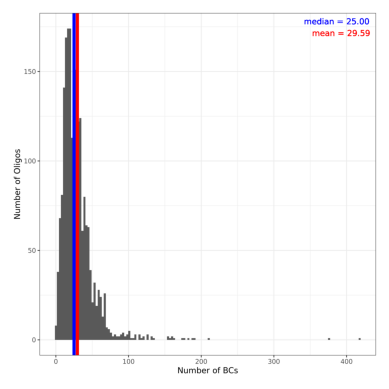

In [42]:
img = plt.imread(os.path.join(results_dir, "assignMPRAworkshop/statistic/assignment.default.png"))
plt.imshow(img)
plt.axis("off")

The median number of barcodes is 24. We usually require each tested sequence to have at least 10 barcodes associated.

We will now take a look at the actual output file of the assignment run, which is a sorted table of `barcodes`, their assigned `sequence IDs`, information about the `quality` of the alignment (fwd/rev reads to designed oligos), and how often this barcode was assigned to this sequence compared to the total number this barcode was observed in the experiment. The information in the quality field is derived from the SAM/BAM output (https://samtools.github.io/hts-specs/SAMv1.pdf) and represents a concatenation of the SAM position, cigar, NM, AM, and mapQ.

In [43]:
assignment = os.path.join(results_dir, "assignMPRAworkshop/assignment_barcodes.default.tsv.gz")
!zcat "{assignment}" | awk 'NR <= 10 {{print $$0}}'

AAAAAAAAAGAAGGG	oligo_006589
AAAAAAAAATCGATC	oligo_006917
AAAAAAAAATGATCT	oligo_211468
AAAAAAAACACATGA	oligo_005412
AAAAAAAACAGTAAG	oligo_006290
AAAAAAAACATAGTT	oligo_006471
AAAAAAAACCAAATA	oligo_189277
AAAAAAAACGAACAG	oligo_005299
AAAAAAAACTATGTT	oligo_005948
AAAAAAAAGAAAAAG	oligo_144933


We would like to know how many different oligos have been included in the final assignment.\
When we compare this number to the number of sequences in our design, we can get a feeling of how many sequences were able to get assigned with their barcodes. This has implications for the proportion of targets that we can eventually analyse and whether each target is supported with sufficiently many barcodes. This information is important for the experiment overall and analyzing the counts of each individual replicate.

In [44]:
assigned_sequences = !zcat "{assignment}" | awk -F'\t' '{{names[$$2]++}} END {{print length(names)}}'

assigned_sequences = int(assigned_sequences[0])
print("Number of sequences we were able to assign: %s"%(assigned_sequences))

designed_sequences = !cat "example_data/design/workshop_design.fa" | grep -v ">" | wc -l
designed_sequences = int(designed_sequences[0])
print("Number of sequences in the initial design: %s"%(designed_sequences))

print(r"Conclusion: %s%% sequences of our initial design can be used in the experimental/counting step"%(round(assigned_sequences/designed_sequences * 100, 1)))

Number of sequences we were able to assign: 2062
Number of sequences in the initial design: 2104
Conclusion: 98.0% sequences of our initial design can be used in the experimental/counting step


### QC report

We have a QC report for the assignment as well as for the experiment workflow. For our run you can find it here:

[MPRAsnakeflow_tutorial/results/assignment/assignMPRAworkshop/qc_report.default.html](MPRAsnakeflow_tutorial/results/assignment/assignMPRAworkshop/qc_report.default.html)

The QC report gives a nice overview of the assignment run and might be the first thing you will look at.

In [ ]:
from IPython.display import IFrame

IFrame(src='./MPRAsnakeflow_tutorial/results/assignment/assignMPRAworkshop/qc_report.default.html', width=700, height=600)